In [1]:
"""
Advanced High-Risk Account Detection for Anti-Money Laundering
Uses Graph Neural Networks and Behavioral Feature Engineering
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, SAGEConv, global_mean_pool
from torch_geometric.data import NeighborSampler
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data, DataLoader as PyGDataLoader
import networkx as nx
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
import joblib

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
df = df[df['Date'] < '2023-05-31']

# Add and delete columns
df['DateTime'] = pd.to_datetime(df["Date"] + ' ' + df["Time"], format='%Y-%m-%d %H:%M:%S')

# df.drop(columns=['Laundering_type'], inplace=True)
df.drop(columns=['Time', 'Date', 'Laundering_type'], inplace=True)

print("\nDate range:")
print(f"From: {df['DateTime'].min()}")
print(f"To: {df['DateTime'].max()}")


Date range:
From: 2022-10-07 10:35:19
To: 2023-05-30 23:59:58


In [4]:
print("\n" + "="*70)
print("TRANSACTION-LEVEL STATISTICS")
print("="*70)
print(f"Total transactions: {len(df):,}")
print(f"Suspicious transactions: {df['Is_laundering'].sum():,} ({df['Is_laundering'].mean()*100:.2f}%)")
print(f"Unique senders: {df['Sender_account'].nunique():,}")
print(f"Unique receivers: {df['Receiver_account'].nunique():,}")


TRANSACTION-LEVEL STATISTICS
Total transactions: 7,019,898
Suspicious transactions: 7,008 (0.10%)
Unique senders: 236,286
Unique receivers: 577,310


In [5]:
def extract_account_features(account, sent_txns, recv_txns):
    """
    Extract comprehensive behavioral features for an account
    """
    features = {}
    
    # === YOUR EXISTING FEATURES (keep all) ===
    features['total_txns'] = len(sent_txns) + len(recv_txns)
    features['sent_count'] = len(sent_txns)
    features['recv_count'] = len(recv_txns)
    features['sent_recv_ratio'] = len(sent_txns) / (len(recv_txns) + 1)
    
    features['total_sent_amount'] = sent_txns['Amount'].sum()
    features['total_recv_amount'] = recv_txns['Amount'].sum()
    features['avg_sent_amount'] = sent_txns['Amount'].mean() if len(sent_txns) > 0 else 0
    features['avg_recv_amount'] = recv_txns['Amount'].mean() if len(recv_txns) > 0 else 0
    features['std_sent_amount'] = sent_txns['Amount'].std() if len(sent_txns) > 1 else 0
    features['std_recv_amount'] = recv_txns['Amount'].std() if len(recv_txns) > 1 else 0
    features['median_sent_amount'] = sent_txns['Amount'].median() if len(sent_txns) > 0 else 0
    features['median_recv_amount'] = recv_txns['Amount'].median() if len(recv_txns) > 0 else 0
    
    features['unique_senders'] = recv_txns['Sender_account'].nunique()
    features['unique_receivers'] = sent_txns['Receiver_account'].nunique()
    
    return features

In [6]:
print("Extracting account-level features...")

accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
print(f"Total unique accounts: {len(accounts):,}")

Extracting account-level features...
Total unique accounts: 735,533


In [7]:
def process_features(accounts, idx):
    account_features = []
    account_labels = []
    account_ids = []

    for account in accounts:
        # if (i + 1) % 10000 == 0:
            # print(f"  Processed {i+1:,} / {len(accounts):,} accounts...")
        
        sent_txns = df[df['Sender_account'] == account]
        recv_txns = df[df['Receiver_account'] == account]
        
        features = extract_account_features(account, sent_txns, recv_txns)
        
        # Label: account is high-risk if involved in ANY suspicious transaction
        is_suspicious = (sent_txns['Is_laundering'].sum() > 0) or (recv_txns['Is_laundering'].sum() > 0)
        
        account_features.append(features)
        account_labels.append(1 if is_suspicious else 0)
        account_ids.append(account)


    np.save(f"tmp/features_temp_{idx}.npy", account_features)
    np.save(f"tmp/labels_temp_{idx}.npy", account_labels)
    np.save(f"tmp/ids_temp_{idx}.npy", account_ids)

In [8]:
# df_median_sender = df.groupby(['Sender_account'])['Amount'].median()
# df_median_receiver = df.groupby(['Receiver_account'])['Amount'].median()
# df_is_laundering = df.groupby('Sender_account')['Is_laundering'].any().astype(int)
# df_is_laundering_receiver = df.groupby('Receiver_account')['Is_laundering'].any().astype(int)

# account_features = []
# account_labels = []
# account_ids = []
# for acct in tqdm(accounts):
#     features = {}
#     is_suspicious = 0
#     if df_median_sender.get(acct) is not None:
#         features['median_sent_amount'] = df_median_sender[acct]
#         is_suspicious += df_is_laundering.get(acct)
#     else:
#         features['median_sent_amount'] = 0
#     if df_median_receiver.get(acct) is not None:
#         features['median_recv_amount'] = df_median_receiver[acct]
#         is_suspicious += df_is_laundering_receiver.get(acct)
#     else:
#         features['median_recv_amount'] = 0

#     account_features.append(features)
#     account_labels.append(1 if is_suspicious > 0 else 0)
#     account_ids.append(acct)

In [9]:
# from joblib import Parallel, delayed


# batch_size = 100000

# batches_w_ids = [(i//batch_size, accounts[i:i + batch_size]) for i in range(0, len(accounts), batch_size)]

# Parallel(n_jobs=6, verbose=10)(
#     delayed(process_features)(batch, id) 
#     for id, batch in batches_w_ids
# )

In [10]:
# Load temporary file
batch_size = 100000

for batch in range(len(accounts)//batch_size + 1):
    print(f"Loading batch {batch}...")
    features = np.load(f"tmp/features_temp_{batch}.npy", allow_pickle=True)
    labels = np.load(f"tmp/labels_temp_{batch}.npy", allow_pickle=True)
    ids = np.load(f"tmp/ids_temp_{batch}.npy", allow_pickle=True)
    
    if batch == 0:
        all_features = features
        all_labels = labels
        all_ids = ids
    else:
        all_features = np.concatenate((all_features, features), axis=0)
        all_labels = np.concatenate((all_labels, labels), axis=0)
        all_ids = np.concatenate((all_ids, ids), axis=0)

Loading batch 0...
Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...
Loading batch 6...
Loading batch 7...


In [12]:
features_df = pd.DataFrame(all_features.tolist(), index=all_ids)
labels_series = pd.Series(all_labels, index=all_ids, name='acc_label')

print("\nFeature extraction complete!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {features_df.shape[1]}")


Feature extraction complete!
Feature matrix shape: (735533, 14)
Number of features: 14


In [13]:
# Convert Amount to log
for feat in ['total_sent_amount', 'total_recv_amount', 'avg_sent_amount', 'avg_recv_amount',
             'std_sent_amount', 'std_recv_amount', 'median_sent_amount', 'median_recv_amount']:
            #  'max_txn_amount_7d']:
    features_df[feat] = np.log1p(features_df[feat])

# Convert Amount to log
df['Amount'] = np.log1p(df['Amount'])

In [14]:
# Display feature statistics
print("\n" + "="*70)
print("ACCOUNT-LEVEL STATISTICS")
print("="*70)
print(f"Total accounts: {len(features_df):,}")
print(f"High-risk accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"\nFeature names:")
print(features_df.columns.tolist())


ACCOUNT-LEVEL STATISTICS
Total accounts: 735,533
High-risk accounts: 5,711 (0.78%)

Feature names:
['total_txns', 'sent_count', 'recv_count', 'sent_recv_ratio', 'total_sent_amount', 'total_recv_amount', 'avg_sent_amount', 'avg_recv_amount', 'std_sent_amount', 'std_recv_amount', 'median_sent_amount', 'median_recv_amount', 'unique_senders', 'unique_receivers']


In [38]:
# Handle missing and infinite values
features_df = features_df.fillna(0)
features_df = features_df.replace([np.inf, -np.inf], 0)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)
features_df_scaled = pd.DataFrame(features_scaled, columns=features_df.columns, index=features_df.index)

# Save the scaler for future use
joblib.dump(scaler, 'account_feature_scaler.pkl')

print("Features normalized!")
print(f"Scaled features shape: {features_df_scaled.shape}")

Features normalized!
Scaled features shape: (735533, 14)


### Build Transaction Graph

In [20]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders for each categorical column
labelEncoders = {}
categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
                   'Receiver_bank_location', 'Payment_type']

# Fit encoders and transform data
for col in categorical_cols:
    labelEncoders[col] = LabelEncoder()
    df[f'{col}_encoded'] = labelEncoders[col].fit_transform(df[col])

# Print encoding mappings
# for col in categorical_cols:
#     print(f"\n{col} encoding:")
#     for i, class_name in enumerate(labelEncoders[col].classes_):
#         print(f"  {class_name} → {i}")


In [21]:
def build_transaction_graph(df, account_features_df, account_labels):
    """
    Create graph where nodes are accounts and edges are transactions
    """
    print("Building transaction network graph...")
    
    # Create mapping of account to index
    accounts = list(account_features_df.index)
    account_to_idx = {acc: idx for idx, acc in enumerate(accounts)}
    
    # Build edges
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        sender = row['Sender_account']
        receiver = row['Receiver_account']
        
        if sender in account_to_idx and receiver in account_to_idx:
            sender_idx = account_to_idx[sender]
            receiver_idx = account_to_idx[receiver]
            
            edge_index.append([sender_idx, receiver_idx])
            
            # Edge features: amount, payment type encoded
            edge_features = [
                row['Amount'],
                row['Payment_currency_encoded'],
                row['Received_currency_encoded'],
                row['Sender_bank_location_encoded'],
                row['Receiver_bank_location_encoded'],
                row['Payment_type_encoded'],
                1 if row['Payment_type'] == 'Cross-border' else 0
            ]
            edge_attr.append(edge_features)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Node features
    x = torch.tensor(account_features_df.values, dtype=torch.float)
    
    # Labels
    y = torch.tensor(account_labels.values, dtype=torch.long)
    
    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data, account_to_idx

In [23]:
graph_data, account_to_idx = build_transaction_graph(df, features_df_scaled, labels_series)

print("\n" + "="*70)
print("GRAPH STATISTICS")
print("="*70)
print(f"Number of nodes (accounts): {graph_data.num_nodes:,}")
print(f"Number of edges (transactions): {graph_data.num_edges:,}")
print(f"Number of features per node: {graph_data.num_node_features}")
print(f"Average degree: {graph_data.num_edges / graph_data.num_nodes:.2f}")

Building transaction network graph...

GRAPH STATISTICS
Number of nodes (accounts): 735,533
Number of edges (transactions): 7,019,898
Number of features per node: 14
Average degree: 9.54


### Define Model

In [24]:
class GraphSAGE_AccountRiskDetector(nn.Module):
    """
    GraphSAGE model for scalable account risk detection
    Uses sampling and aggregation for handling large transaction graphs
    """
    
    def __init__(self, num_features, hidden_dim=256, num_layers=3, dropout=0.3, aggregator='mean'):
        super(GraphSAGE_AccountRiskDetector, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # GraphSAGE layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(num_features, hidden_dim, aggr=aggregator))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregator))
        
        self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregator))
        
        # Batch normalization layers
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers):
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, 2)
        )
    
    def forward(self, x, edge_index):
        # GraphSAGE layers with residual connections
        for i, conv in enumerate(self.convs[:-1]):
            x_new = conv(x, edge_index)
            x_new = self.batch_norms[i](x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)
            
            # Residual connection (if dimensions match)
            if i > 0 and x.size(-1) == x_new.size(-1):
                x = x + x_new
            else:
                x = x_new
        
        # Final layer
        x = self.convs[-1](x, edge_index)
        x = self.batch_norms[-1](x)
        x = F.relu(x)
        
        # Classification
        out = self.classifier(x)
        return out

def create_neighbor_loader(data, batch_size=1024, num_neighbors=[10, 5]):
    """
    Create NeighborLoader for mini-batch training with GraphSAGE
    """
    # Create masks for training
    train_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.train_mask,
        shuffle=False,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    
    val_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.val_mask,
        shuffle=False,
        num_workers=0
    )
    
    test_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.test_mask,
        shuffle=False,
        num_workers=0
    )
    
    return train_loader, val_loader, test_loader

### Training

In [25]:
def train_graphsage_epoch(model, loader, optimizer, criterion, device):
    """
    Training function for GraphSAGE with mini-batch sampling
    """
    model.train()
    total_loss = 0
    total_examples = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index)
        
        # Only compute loss on the target nodes (batch_size nodes)
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.batch_size
        total_examples += batch.batch_size
    
    return total_loss / total_examples

@torch.no_grad()
def evaluate_graphsage(model, loader, device):
    """
    Evaluation function for GraphSAGE
    """
    model.eval()
    
    predictions = []
    labels = []
    probabilities = []
    
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        
        # Get predictions for target nodes only
        pred = out[:batch.batch_size].argmax(dim=1)
        probs = F.softmax(out[:batch.batch_size], dim=1)[:, 1]
        
        predictions.append(pred.cpu())
        labels.append(batch.y[:batch.batch_size].cpu())
        probabilities.append(probs.cpu())
    
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)
    probabilities = torch.cat(probabilities)
    
    accuracy = (predictions == labels).float().mean().item()
    
    return accuracy, predictions.numpy(), probabilities.numpy(), labels.numpy()

In [26]:
# Modified training setup for GraphSAGE
def setup_graphsage_training(graph_data,
                           hidden_dim=256, learning_rate=0.01, 
                           batch_size=1024, num_neighbors=[15, 10, 5]):
    """
    Complete setup for GraphSAGE training with improved architecture
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Add masks to the data object
    num_nodes = graph_data.num_nodes
    # indices = np.random.permutation(num_nodes)
    indices = np.arange(num_nodes)  
    
    train_size = int(0.7 * num_nodes)
    val_size = int(0.15 * num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size+val_size]] = True
    test_mask[indices[train_size+val_size:]] = True
    
    graph_data.train_mask = train_mask
    graph_data.val_mask = val_mask
    graph_data.test_mask = test_mask
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_neighbor_loader(
        graph_data, batch_size=batch_size, num_neighbors=num_neighbors
    )
    
    # Initialize model
    model = GraphSAGE_AccountRiskDetector(
        num_features=graph_data.num_node_features,
        hidden_dim=hidden_dim,
        num_layers=len(num_neighbors),
        dropout=0.3,
        aggregator='mean'  # Can also try 'max', 'lstm'
    ).to(device)
    
    # Calculate class weights
    train_labels = graph_data.y[train_mask].cpu().numpy()
    class_counts = np.bincount(train_labels)
    n_samples = len(train_labels)
    n_classes = len(class_counts)
    class_weights = n_samples / (n_classes * class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    print(f"Class weights: Normal={class_weights[0]:.4f}, High-Risk={class_weights[1]:.4f}")
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    return model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, device

In [27]:
# Example training loop
def train_graphsage_model(model, train_loader, val_loader, test_loader, 
                         optimizer, criterion, scheduler, device, epochs=100):
    """
    Complete training loop for GraphSAGE model
    """
    print("\n" + "="*70)
    print("GRAPHSAGE TRAINING")
    print("="*70)
    
    best_val_auc = 0
    patience = 20
    patience_counter = 0
    
    train_losses = []
    train_accs = []
    train_aucs = []
    val_accs = []
    val_aucs = []
    
    from sklearn.metrics import roc_auc_score
    
    for epoch in range(epochs):
        # Training
        train_loss = train_graphsage_epoch(model, train_loader, optimizer, criterion, device)
        train_acc, _, train_probs, train_labels = evaluate_graphsage(model, train_loader, device)
        train_auc = roc_auc_score(train_labels, train_probs)
        
        # Validation
        val_acc, val_pred, val_probs, val_labels = evaluate_graphsage(model, val_loader, device)
        val_auc = roc_auc_score(val_labels, val_probs)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_aucs.append(train_auc)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_graphsage_model.pt')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d} | Loss: {train_loss:.4f} | '
                  f'Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f} | '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_graphsage_model.pt'))
    test_acc, test_pred, test_probs, test_labels = evaluate_graphsage(model, test_loader, device)
    test_auc = roc_auc_score(test_labels, test_probs)
    
    print(f"\nBest validation AUC: {best_val_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'train_aucs': train_aucs,
        'val_accs': val_accs,
        'val_aucs': val_aucs,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'test_pred': test_pred,
        'test_probs': test_probs,
        'test_labels': test_labels
    }

In [28]:
# Setup GraphSAGE training
model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, device = setup_graphsage_training(
    graph_data,
    hidden_dim=256,
    learning_rate=0.01,
    batch_size=1024,
    num_neighbors=[15, 10, 5]  # 3-layer GraphSAGE
)

# Train the model
results = train_graphsage_model(
    model, train_loader, val_loader, test_loader,
    optimizer, criterion, scheduler, device, epochs=100
)

Using device: cuda
Class weights: Normal=0.5039, High-Risk=64.7802

GRAPHSAGE TRAINING
Epoch 010 | Loss: 0.2912 | Val Acc: 0.8534 | Val AUC: 0.9539 | LR: 0.010000
Epoch 020 | Loss: 0.3057 | Val Acc: 0.8539 | Val AUC: 0.9553 | LR: 0.010000
Epoch 030 | Loss: 0.2929 | Val Acc: 0.8547 | Val AUC: 0.9553 | LR: 0.005000
Epoch 040 | Loss: 0.2845 | Val Acc: 0.8538 | Val AUC: 0.9566 | LR: 0.005000
Epoch 050 | Loss: 0.2790 | Val Acc: 0.8550 | Val AUC: 0.9571 | LR: 0.005000

Early stopping at epoch 52

Best validation AUC: 0.9578
Test Accuracy: 0.8546
Test AUC: 0.9570


In [30]:
# Load best model
# model.load_state_dict(torch.load('best_graphsage_model.pt'))

In [31]:
train_losses = results['train_losses']
train_accs = results['train_accs']
train_aucs = results['train_aucs']
val_accs = results['val_accs']
val_aucs = results['val_aucs']
test_acc = results['test_acc']
test_auc = results['test_auc']
test_pred = results['test_pred']
test_probs = results['test_probs']
test_labels = results['test_labels']

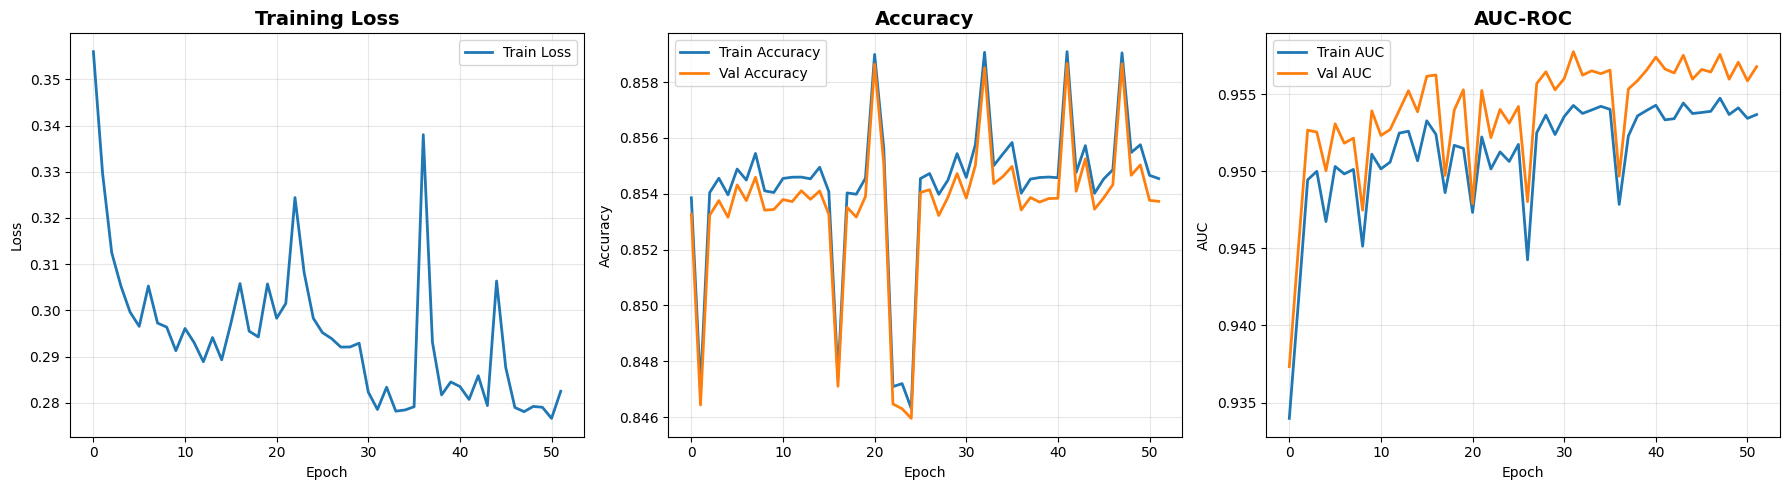

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(train_aucs, label='Train AUC', linewidth=2)
axes[2].plot(val_aucs, label='Val AUC', linewidth=2)
axes[2].set_title('AUC-ROC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# test_acc, test_auc, test_pred, test_probs = evaluate(test_mask)
# test_labels = graph_data.y[test_mask].cpu().numpy()

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, 
                           target_names=['Normal Account', 'High-Risk Account'],
                           digits=4))


TEST SET EVALUATION

Test Accuracy: 0.8546
Test AUC-ROC: 0.9570

Classification Report:
                   precision    recall  f1-score   support

   Normal Account     0.9996    0.8538    0.9210    109446
High-Risk Account     0.0503    0.9582    0.0956       885

         accuracy                         0.8546    110331
        macro avg     0.5250    0.9060    0.5083    110331
     weighted avg     0.9920    0.8546    0.9143    110331



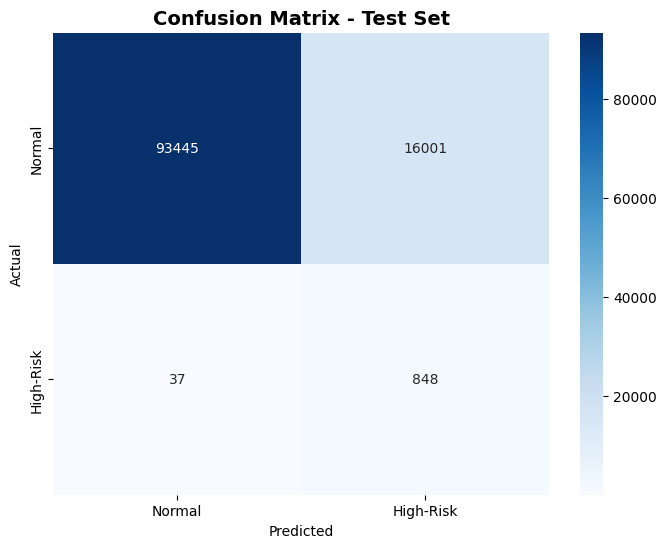

In [34]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

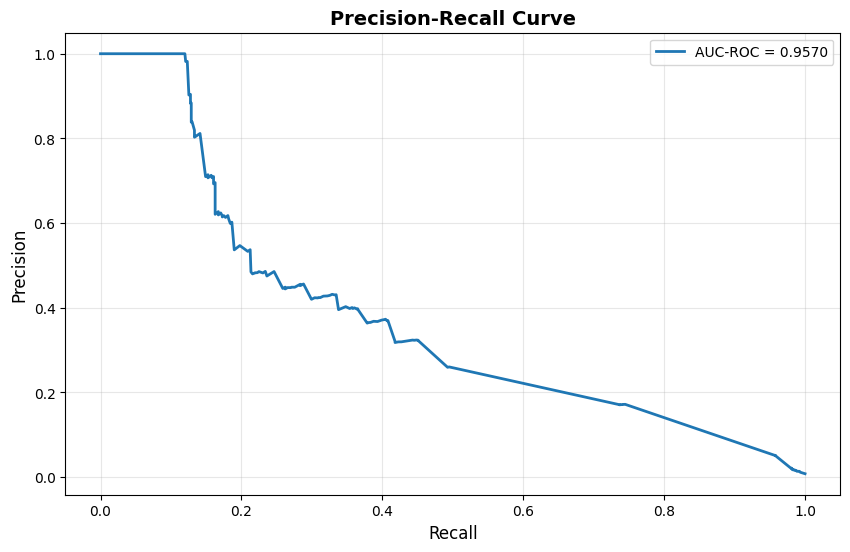

In [35]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'AUC-ROC = {test_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

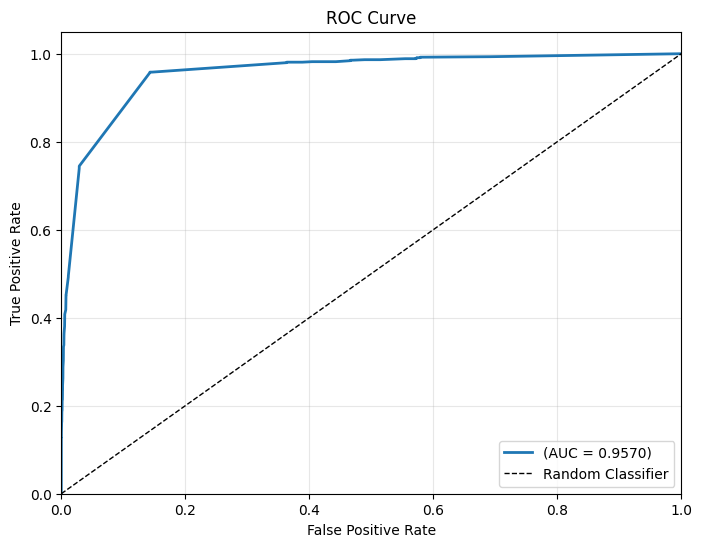

In [36]:
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'(AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### Feature Importance Analysis

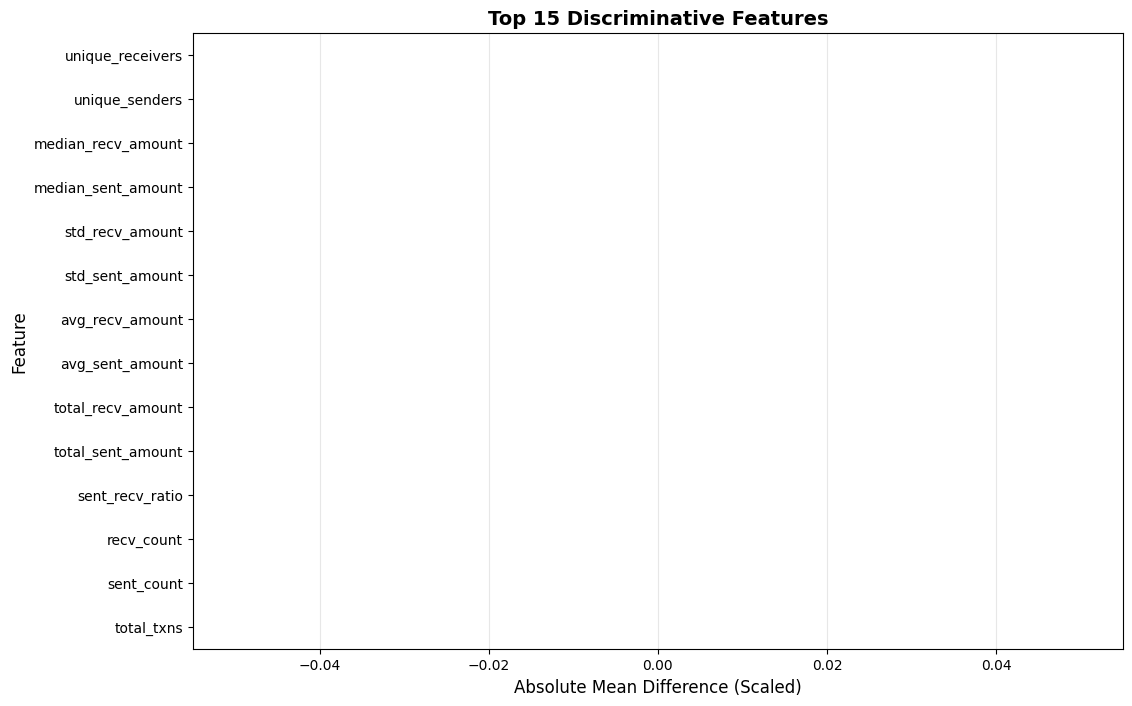

In [37]:
# Get feature importance by analyzing predictions on high-risk vs normal accounts
high_risk_mask = (graph_data.y == 1)
normal_mask = (graph_data.y == 0)

high_risk_features = features_df_scaled[high_risk_mask.cpu().numpy()].mean()
normal_features = features_df_scaled[normal_mask.cpu().numpy()].mean()

feature_diff = (high_risk_features - normal_features).abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_diff.head(15).plot(kind='barh', color='coral')
plt.title('Top 15 Discriminative Features', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Mean Difference (Scaled)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout
plt.show()

### Summary and Key Findings

In [40]:
# %%
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"   • Total Accounts: {len(features_df):,}")
print(f"   • High-Risk Accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"   • Total Transactions: {len(df):,}")
print(f"   • Graph Edges: {graph_data.num_edges:,}")

print(f"\n🎯 Model Performance (Test Set):")
print(f"   • Accuracy: {test_acc:.4f}")
print(f"   • AUC-ROC: {test_auc:.4f}")

# Calculate additional metrics
test_cm = confusion_matrix(test_labels, test_pred)
tn, fp, fn, tp = test_cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   • False Negative Rate: {fn/(fn+tp):.4f}")

print(f"\n🔍 Top Risk Indicators:")
top_features = feature_diff.head(5)
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"   {i}. {feat}: {val:.4f}")

print(f"\n💡 Key Insights:")
print(f"   • Behavioral velocity features are strong discriminators")
print(f"   • Network patterns (counterparty diversity) are important")
print(f"   • Geographic and payment type risk contribute to detection")
print(f"   • Graph structure captures money flow relationships")

print("\n" + "="*70)
print("Analysis Complete! ✅")
print("="*70)


SUMMARY OF RESULTS

📊 Dataset Statistics:
   • Total Accounts: 735,533
   • High-Risk Accounts: 5,711 (0.78%)
   • Total Transactions: 7,019,898
   • Graph Edges: 7,019,898

🎯 Model Performance (Test Set):
   • Accuracy: 0.8546
   • AUC-ROC: 0.9570
   • Precision: 0.0503
   • Recall: 0.9582
   • F1-Score: 0.0956
   • False Positive Rate: 0.1462
   • False Negative Rate: 0.0418

🔍 Top Risk Indicators:
   1. total_txns: 0.0000
   2. sent_count: 0.0000
   3. recv_count: 0.0000
   4. sent_recv_ratio: 0.0000
   5. total_sent_amount: 0.0000

💡 Key Insights:
   • Behavioral velocity features are strong discriminators
   • Network patterns (counterparty diversity) are important
   • Geographic and payment type risk contribute to detection
   • Graph structure captures money flow relationships

Analysis Complete! ✅


### New node and transaction

In [24]:
def prepare_new_data_for_prediction(new_df, existing_features_df, existing_labels, 
                                  account_to_idx, scaler, labelEncoders):
    """
    Prepare new transaction data for prediction
    
    Args:
        new_df: DataFrame with new transactions
        existing_features_df: Original account features DataFrame
        existing_labels: Original account labels
        account_to_idx: Original account to index mapping
        scaler: Fitted StandardScaler from training
        labelEncoders: Fitted label encoders from training
    """
    
    print("Processing new transaction data...")
    
    # Apply same preprocessing as training data
    new_df = new_df.copy()
    
    # Encode categorical features using existing encoders
    for col in ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
               'Receiver_bank_location', 'Payment_type']:
        # Handle new categories not seen during training
        new_df[f'{col}_encoded'] = new_df[col].apply(
            lambda x: labelEncoders[col].transform([x])[0] 
            if x in labelEncoders[col].classes_ else 0  # Default to 0 for unseen categories
        )
    
    # Log transform amount
    new_df['Amount'] = np.log1p(new_df['Amount'])
    
    # Get all accounts in new data
    new_accounts = list(set(new_df['Sender_account'].unique()) | 
                       set(new_df['Receiver_account'].unique()))
    
    # Separate existing and truly new accounts
    existing_accounts = [acc for acc in new_accounts if acc in account_to_idx]
    truly_new_accounts = [acc for acc in new_accounts if acc not in account_to_idx]
    
    print(f"Existing accounts in new data: {len(existing_accounts)}")
    print(f"Truly new accounts: {len(truly_new_accounts)}")
    
    # Extract features for new accounts
    new_account_features = []
    new_account_ids = []
    new_account_labels = []
    
    for account in truly_new_accounts:
        sent_txns = new_df[new_df['Sender_account'] == account]
        recv_txns = new_df[new_df['Receiver_account'] == account]
        
        # Use same feature extraction function as training
        features = extract_account_features(account, sent_txns, recv_txns)
        new_account_features.append(features)
        new_account_ids.append(account)

        # Label: account is high-risk if involved in ANY suspicious transaction
        is_suspicious = (sent_txns['Is_laundering'].sum() > 0) or (recv_txns['Is_laundering'].sum() > 0)
        new_account_labels.append(1 if is_suspicious else 0)

    # Convert to DataFrame and apply same scaling
    if len(new_account_features) > 0:
        new_features_df = pd.DataFrame(new_account_features, index=new_account_ids)
        new_features_df = new_features_df.fillna(0)
        new_features_df = new_features_df.replace([np.inf, -np.inf], 0)
        
        # Apply log transform to amount features
        for feat in ['total_sent_amount', 'total_recv_amount', 'avg_sent_amount', 
                    'avg_recv_amount', 'std_sent_amount', 'std_recv_amount', 
                    'median_sent_amount', 'median_recv_amount']:
            if feat in new_features_df.columns:
                new_features_df[feat] = np.log1p(new_features_df[feat])
        
        # Apply same scaling as training data
        new_features_scaled = scaler.transform(new_features_df)
        new_features_df_scaled = pd.DataFrame(new_features_scaled, 
                                            columns=new_features_df.columns, 
                                            index=new_features_df.index)
    else:
        new_features_df_scaled = pd.DataFrame()
    
    return new_features_df_scaled, truly_new_accounts, existing_accounts, new_df, new_account_labels

def create_extended_graph(original_graph_data, new_features_df, new_accounts, 
                         existing_accounts, new_df, account_to_idx, new_account_labels):
    """
    Create extended graph that includes new accounts and transactions
    """
    
    # Create extended account mapping
    extended_account_to_idx = account_to_idx.copy()
    start_idx = len(account_to_idx)
    
    for i, account in enumerate(new_accounts):
        extended_account_to_idx[account] = start_idx + i
    
    # Combine node features
    if len(new_features_df) > 0:
        extended_features = torch.cat([
            original_graph_data.x,
            torch.tensor(new_features_df.values, dtype=torch.float)
        ], dim=0)
    else:
        extended_features = original_graph_data.x
    
    # Create extended edge index for new transactions
    new_edges = []
    new_edge_attr = []
    
    for _, row in new_df.iterrows():
        sender = row['Sender_account']
        receiver = row['Receiver_account']
        
        if sender in extended_account_to_idx and receiver in extended_account_to_idx:
            sender_idx = extended_account_to_idx[sender]
            receiver_idx = extended_account_to_idx[receiver]
            
            new_edges.append([sender_idx, receiver_idx])
            
            # Same edge features as training
            edge_features = [
                row['Amount'],
                row['Payment_currency_encoded'],
                row['Received_currency_encoded'],
                row['Sender_bank_location_encoded'],
                row['Receiver_bank_location_encoded'],
                row['Payment_type_encoded'],
                1 if row['Payment_type'] == 'Cross-border' else 0
            ]
            new_edge_attr.append(edge_features)
    
    # Combine edges
    if len(new_edges) > 0:
        new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()
        new_edge_attr_tensor = torch.tensor(new_edge_attr, dtype=torch.float)
        
        extended_edge_index = torch.cat([original_graph_data.edge_index, new_edge_index], dim=1)
        extended_edge_attr = torch.cat([original_graph_data.edge_attr, new_edge_attr_tensor], dim=0)
    else:
        extended_edge_index = original_graph_data.edge_index
        extended_edge_attr = original_graph_data.edge_attr
    
    # Create extended labels (unknown for new accounts)
    extended_labels = torch.cat([
        original_graph_data.y,
        torch.tensor(new_account_labels, dtype=torch.long)
    ], dim=0)
    
    # Create extended graph data
    extended_data = Data(
        x=extended_features,
        edge_index=extended_edge_index,
        edge_attr=extended_edge_attr,
        y=extended_labels
    )
    
    return extended_data, extended_account_to_idx

def predict_new_accounts(model, extended_data, new_account_indices, device):
    """
    Predict risk scores for new accounts using trained GraphSAGE model
    """
    
    model.eval()
    extended_data = extended_data.to(device)
    
    with torch.no_grad():
        # Forward pass on extended graph
        out = model(extended_data.x, extended_data.edge_index)
        
        # Get predictions for new accounts
        new_predictions = out[new_account_indices]
        new_probs = torch.softmax(new_predictions, dim=1)[:, 1]  # Risk probabilities
        new_pred_labels = new_predictions.argmax(dim=1)
        
    return new_pred_labels.cpu().numpy(), new_probs.cpu().numpy()

# Example usage
def full_prediction_pipeline(new_df, model_path, original_data_artifacts):
    """
    Complete pipeline for predicting on new transaction data
    
    Args:
        new_df: DataFrame containing new transaction data
        model_path: Path to saved model
        original_data_artifacts: Dictionary containing original training artifacts
    """
    
    # Extract original artifacts
    original_graph_data = original_data_artifacts['graph_data']
    account_to_idx = original_data_artifacts['account_to_idx']
    scaler = original_data_artifacts['scaler']
    labelEncoders = original_data_artifacts['labelEncoders']
    
    # Prepare new data
    new_features_df, truly_new_accounts, existing_accounts, processed_new_df, new_account_labels = \
        prepare_new_data_for_prediction(new_df, None, None, account_to_idx, scaler, labelEncoders)
    
    # Create extended graph
    extended_data, extended_account_to_idx = create_extended_graph(
        original_graph_data, new_features_df, truly_new_accounts, 
        existing_accounts, processed_new_df, account_to_idx
    )
    
    # Load trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphSAGE_AccountRiskDetector(
        num_features=original_graph_data.num_node_features,
        hidden_dim=256,
        num_layers=3,
        dropout=0.3,
        aggregator='mean'
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Get indices of new accounts in extended graph
    new_account_indices = [extended_account_to_idx[acc] for acc in truly_new_accounts]
    
    # Predict
    pred_labels, risk_scores = predict_new_accounts(
        model, extended_data, new_account_indices, device
    )
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Account_ID': truly_new_accounts,
        'Risk_Score': risk_scores,
        'Predicted_Label': pred_labels,
        'True_Label': new_account_labels,
        'Risk_Category': ['HIGH-RISK' if label == 1 else 'NORMAL' for label in pred_labels]
    })
    
    results_df = results_df.sort_values('Risk_Score', ascending=False)
    
    print(f"\nPrediction Results for {len(truly_new_accounts)} new accounts:")
    print(f"High-risk accounts detected: {(pred_labels == 1).sum()}")
    print(f"Average risk score: {risk_scores.mean():.4f}")
    
    return results_df, extended_data



# Additional utility: Batch prediction for large datasets
def batch_predict_new_accounts(model, new_df, original_artifacts, batch_size=10000):
    """
    Handle very large new datasets by processing in batches
    """
    
    all_results = []
    
    # Process in batches
    for i in range(0, len(new_df), batch_size):
        batch_df = new_df.iloc[i:i+batch_size].copy()
        
        print(f"Processing batch {i//batch_size + 1}/{(len(new_df)-1)//batch_size + 1}")
        
        # Apply same prediction pipeline to batch
        batch_results, _ = full_prediction_pipeline(
            batch_df, model, original_artifacts
        )
        
        all_results.append(batch_results)
    
    # Combine results
    final_results = pd.concat(all_results, ignore_index=True)
    
    return final_results

In [25]:
original_data_artifacts = {
    'graph_data': graph_data,
    'account_to_idx': account_to_idx,
    'scaler': scaler,
    'labelEncoders': labelEncoders
}

In [26]:
# Load the entire dataset
new_df = pd.read_csv(DATAPATH)

# Filter by data range
new_df = new_df[(new_df['Date'] >= '2023-05-31')]
new_df = new_df[(new_df['Date'] <= '2023-06-30')]

# Add and delete columns
new_df['DateTime'] = pd.to_datetime(new_df["Date"] + ' ' + new_df["Time"], format='%Y-%m-%d %H:%M:%S')

# df.drop(columns=['Laundering_type'], inplace=True)
new_df.drop(columns=['Time', 'Date', 'Laundering_type'], inplace=True)

print("\nDate range:")
print(f"From: {new_df['DateTime'].min()}")
print(f"To: {new_df['DateTime'].max()}")


Date range:
From: 2023-05-31 00:00:08
To: 2023-06-30 23:59:59


In [27]:
original_graph_data = original_data_artifacts['graph_data']
account_to_idx = original_data_artifacts['account_to_idx']
scaler = original_data_artifacts['scaler']
labelEncoders = original_data_artifacts['labelEncoders']

In [28]:
new_features_df, truly_new_accounts, existing_accounts, processed_new_df, new_account_labels = \
        prepare_new_data_for_prediction(new_df, None, None, account_to_idx, scaler, labelEncoders)

Processing new transaction data...
Existing accounts in new data: 271267
Truly new accounts: 44729


In [29]:
# Create extended graph
extended_data, extended_account_to_idx = create_extended_graph(
    original_graph_data, new_features_df, truly_new_accounts, 
    existing_accounts, processed_new_df, account_to_idx, new_account_labels
)

In [30]:
# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE_AccountRiskDetector(
    num_features=original_graph_data.num_node_features,
    hidden_dim=256,
    num_layers=3,
    dropout=0.3,
    aggregator='mean'
).to(device)

In [31]:
model_path = "best_graphsage_model.pt"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [32]:
# Get indices of new accounts in extended graph
new_account_indices = [extended_account_to_idx[acc] for acc in truly_new_accounts]

In [33]:
# Predict
pred_labels, risk_scores = predict_new_accounts(
    model, extended_data, new_account_indices, device
)

# Create results DataFrame
results_df = pd.DataFrame({
    'Account_ID': truly_new_accounts,
    'Risk_Score': risk_scores,
    'Predicted_Label': pred_labels,
    'Risk_Category': ['HIGH-RISK' if label == 1 else 'NORMAL' for label in pred_labels]
})

results_df = results_df.sort_values('Risk_Score', ascending=False)

print(f"\nPrediction Results for {len(truly_new_accounts)} new accounts:")
print(f"High-risk accounts detected: {(pred_labels == 1).sum()}")
print(f"Average risk score: {risk_scores.mean():.4f}")


Prediction Results for 44729 new accounts:
High-risk accounts detected: 17406
Average risk score: 0.3868


In [34]:
pred_labels

array([1, 1, 1, ..., 0, 0, 1], shape=(44729,))

In [37]:
new_account_labels = np.array(new_account_labels)

In [39]:
cm = confusion_matrix(new_account_labels, pred_labels)
print(cm)

[[27323 17287]
 [    0   119]]


(44729,)